# Chapter 6 Mona Lisa

In [1]:
# numerical and scientific computing libraries
import numpy as np
import scipy as sp

# plotting libraries 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for pretty printing
np.set_printoptions(4, linewidth=100, suppress=True)

## SVD of Mona Lisa

As our image, let us pick the Mona Lisa in a size of 687x1024 downloaded at https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg

This image is stored in local directory under the following file name.

In [3]:
filename ='Mona_Lisa-687x1024.jpg'

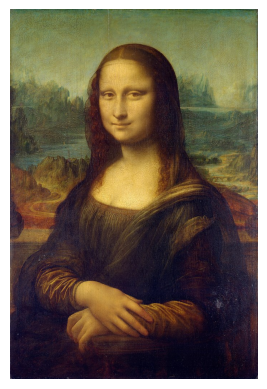

In [4]:
from PIL import Image

# Open and display the image
try:
    img_from_file = Image.open(filename)
    plt.imshow(img_from_file)
    plt.axis('off')
    plt.show()
except IOError as e:
    print(f"Error opening image file: {e}")

### Basic analysis of image

In [5]:
# let's print the shape of img_from_file
print(f"Image shape: {np.array(img_from_file).shape}")

Image shape: (1024, 687, 3)


In [6]:
name_color = ['red', 'green', 'blue']

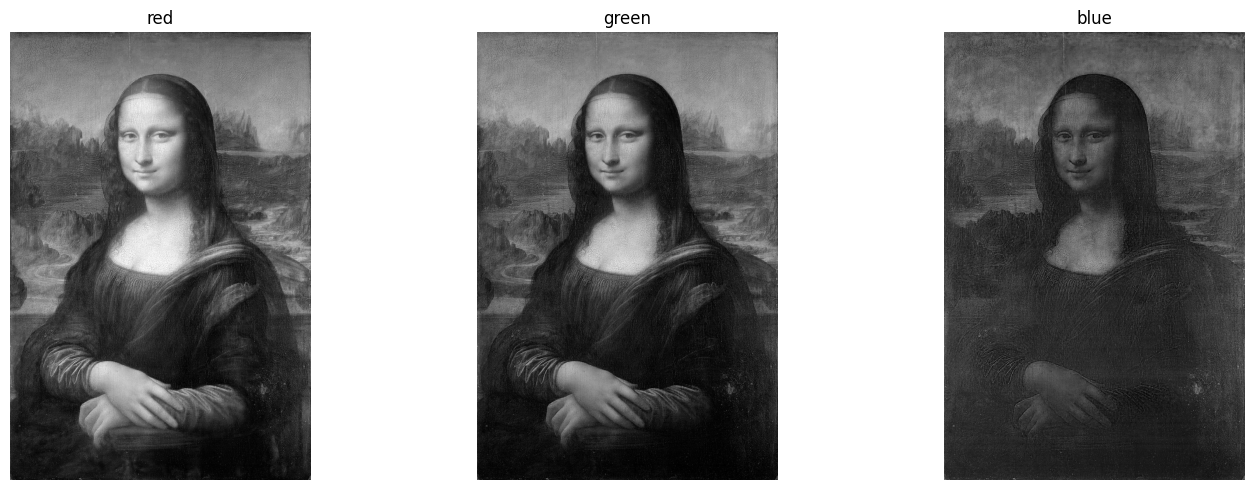

In [7]:
# let's draw the three channels separately side-by-side.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(np.array(img_from_file)[:,:,i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(name_color[i])
plt.tight_layout()
plt.show()

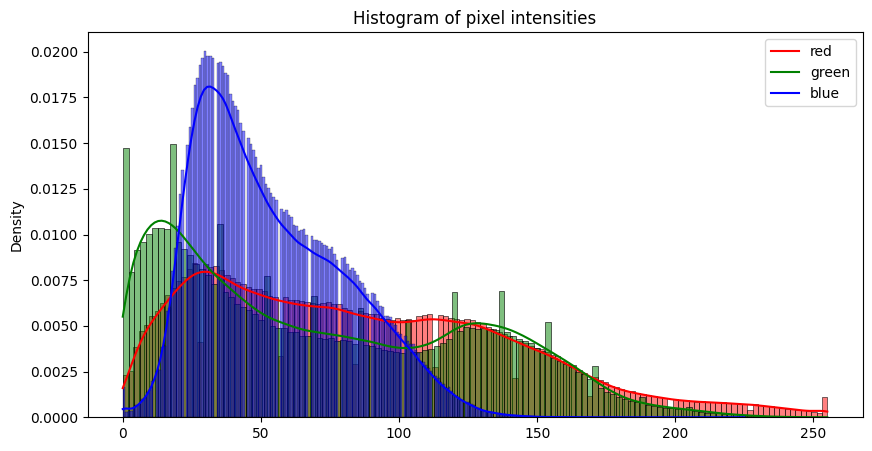

In [8]:
# let's plot the histograms of the pixel intensities of three channels on top of each other.
# let's make the plot pretty.
# distplot is deprecated. let's use another function.
# let's normalize the histograms to make them comparable.
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(3):
    sns.histplot(np.array(img_from_file)[:,:,i].ravel(), color=name_color[i], kde=True, stat='density', ax=ax, label=f"Channel {i+1}")
ax.set_title("Histogram of pixel intensities")
ax.legend(name_color)
plt.show()


### SVD of Mona Lisa

Reconstructed image shape with centering: (1024, 687, 3) with 30 singular values


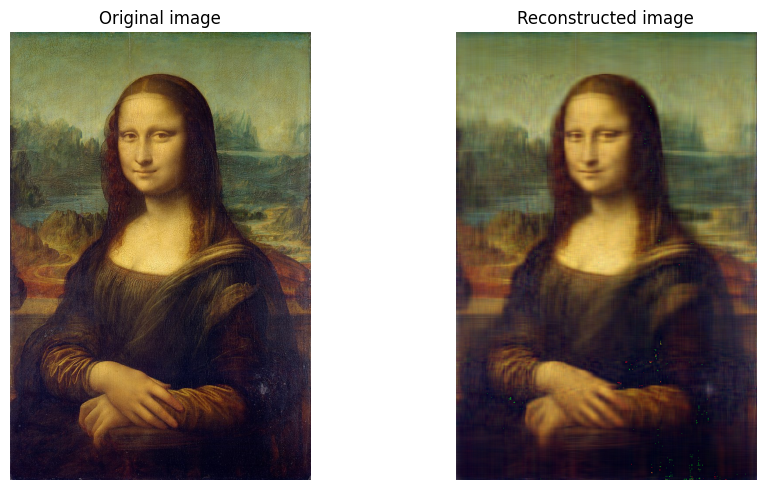

Explained variation: 
[[0.5243 0.6582 0.7485 0.7995 0.8367 0.8566 0.8721 0.8823 0.8898 0.8962 0.9009 0.9054 0.9088
  0.912  0.9149 0.9172 0.9194 0.9216 0.9234 0.9251 0.9266 0.9281 0.9295 0.9308 0.9319 0.933
  0.934  0.9349 0.9358 0.9366]
 [0.5971 0.737  0.8019 0.8468 0.8688 0.8814 0.8924 0.8987 0.9042 0.9094 0.9133 0.9163 0.9193
  0.9218 0.9241 0.9261 0.9279 0.9297 0.9311 0.9323 0.9334 0.9343 0.9353 0.9361 0.937  0.9378
  0.9386 0.9393 0.94   0.9406]
 [0.4707 0.6062 0.6554 0.676  0.6907 0.7047 0.7135 0.7221 0.7297 0.7349 0.7388 0.7423 0.7457
  0.7487 0.7516 0.7544 0.7568 0.759  0.761  0.7628 0.7646 0.7663 0.7681 0.7698 0.7714 0.773
  0.7745 0.7761 0.7775 0.779 ]]


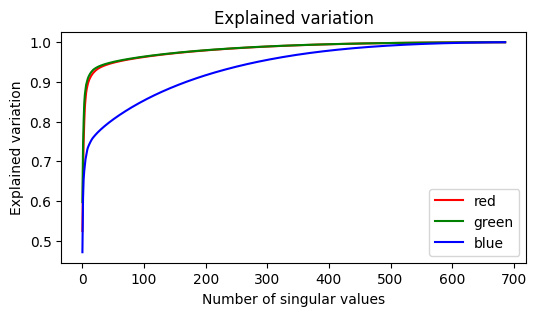

In [9]:
# Let's reconstruct the image using the first k singular values of each channel.
k = 30
# with or without mean subtraction
mean_subtraction = True
# with or without printing the shapes
verbose = False

# Initialize an empty list to store the reconstructed channels
channel_reconstructed = []
# Convert the image to a float64 array before processing
img_float = np.array(img_from_file).astype('float64')

# Print the shapes of the image
if verbose:
    print(f"Image shape: {img_float.shape}")

s_list = np.zeros((3, img_float.shape[1]))
# Extract 3 channels of the image as separate numpy arrays and process them
for i in range(3):
    channel = img_float[:, :, i]
    if verbose:
        print(f"Channel {i+1} shape: {channel.shape}")
    
    # Subtract the column-wise mean
    if mean_subtraction:
        img_mean = np.mean(channel, axis=0)
        if verbose:
            print(f"Channel {i+1} mean shape: {img_mean.shape}")
        channel -= img_mean  # Subtract mean from the channel
    
    # do compact svd on the channel
    U, S, Vt = np.linalg.svd(channel, full_matrices=False)
    s_list[i, :] = S
    
    # Print the shapes of U, S, and Vt
    if verbose:
        print(f"Channel {i+1} U shape: {U.shape}")
        print(f"Channel {i+1} S shape: {S.shape}")
        print(f"Channel {i+1} Vt shape: {Vt.shape}")
    
    
    # Reconstruct the channel in a list using the first k singular values
    if mean_subtraction:
        channel_reconstructed.append(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :] + img_mean)
        if verbose:
            print(f"Channel {i+1} reconstructed shape with centering: {channel_reconstructed[i].shape}")
    else:
        channel_reconstructed.append(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :])
        if verbose:
            print(f"Channel {i+1} reconstructed shape without centering: {channel_reconstructed[i].shape}")

# Combine the reconstructed channels into a single image
img_reconstructed = np.stack(channel_reconstructed, axis=2)
if mean_subtraction:
    print(f"Reconstructed image shape with centering: {img_reconstructed.shape} with {k} singular values")
else:
    print(f"Reconstructed image shape without centering: {img_reconstructed.shape} with {k} singular values")

# If needed, you can convert the processed image back to uint8
img_processed = img_reconstructed.astype('uint8')

# Display the original and processed images side-by-side, compactly and prettily
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_from_file)
ax[0].axis('off')
ax[0].set_title("Original image")
ax[1].imshow(img_processed)
ax[1].axis('off')
ax[1].set_title("Reconstructed image")
plt.tight_layout()
plt.show()

# calculate the explained variation for each channel
explained_variation = np.zeros(s_list.shape)
for i in range(3):
    explained_variation[i, :] = np.cumsum(s_list[i, :]**2) / np.sum(s_list[i, :]**2)
# print the explained variance
print('Explained variation: ')
print(explained_variation[:,:k])
# plot the explained variation
fig, ax = plt.subplots(figsize=(6, 3))
for i in range(3):
    ax.plot(explained_variation[i, :], label=f"Channel {i+1}", color=name_color[i])
ax.set_title("Explained variation")
ax.set_xlabel("Number of singular values")
ax.set_ylabel("Explained variation")
ax.legend(name_color)
plt.show()


### SVD of Mona Lisa with and without mean shifting simultaneously.

Reconstructed image shape: (1024, 687, 3) with 1 singular values


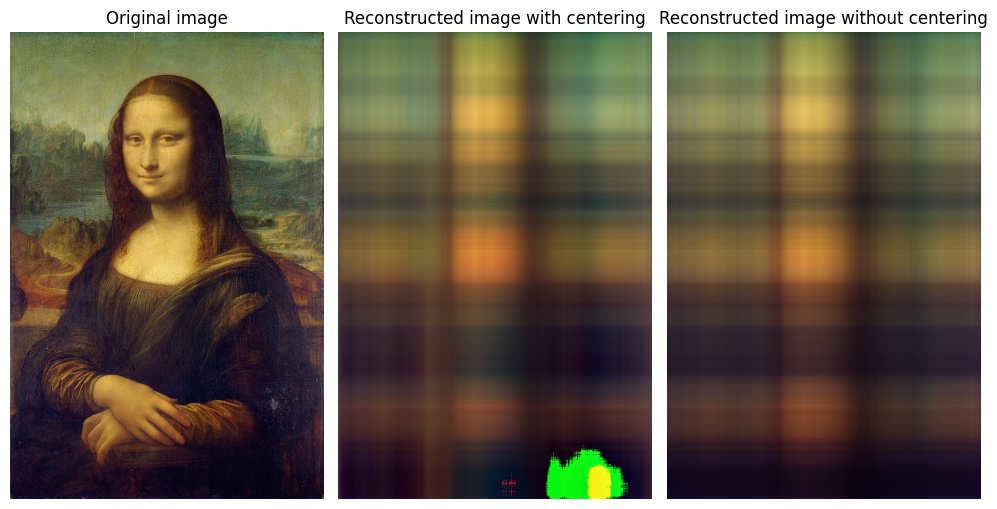

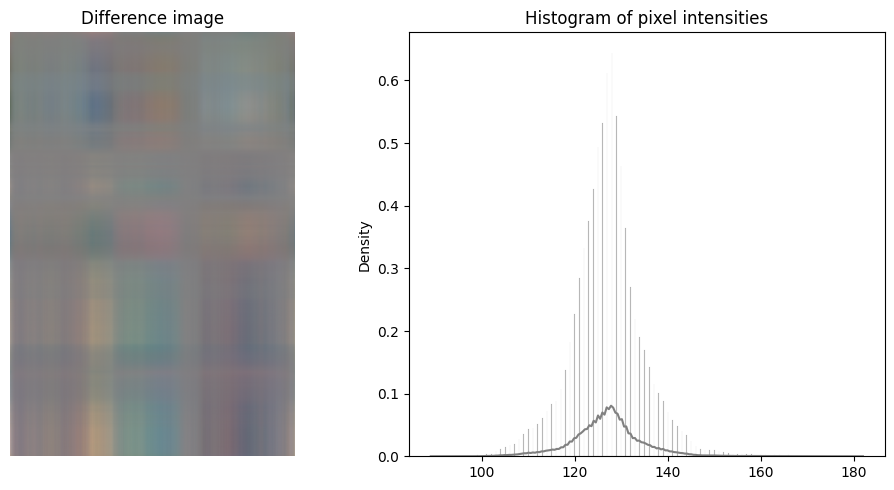

In [10]:
# Let's reconstruct the image using the first k singular values of each channel.
k = 1
# with or without printing the shapes
verbose = False

# Initialize an empty list to store the reconstructed channels
channel_reconstructed_w_centering = []
channel_reconstructed_wo_centering = []
# Convert the image to a float64 array before processing
img_float = np.array(img_from_file).astype('float64')

# Print the shapes of the image
if verbose:
    print(f"Image shape: {img_float.shape}")

# Extract 3 channels of the image as separate numpy arrays and process them
for i in range(3):
    channel = img_float[:, :, i]
    if verbose:
        print(f"Channel {i+1} shape: {channel.shape}")
    
    # Subtract the column-wise mean
    if mean_subtraction:
        img_mean = np.mean(channel, axis=0)
        if verbose:
            print(f"Channel {i+1} mean shape: {img_mean.shape}")
        channel -= img_mean  # Subtract mean from the channel
    
    # do compact svd on the channel
    U, S, Vt = np.linalg.svd(channel, full_matrices=False)
    if verbose:
        print(f"Channel {i+1} U shape: {U.shape}")
        print(f"Channel {i+1} S shape: {S.shape}")
        print(f"Channel {i+1} Vt shape: {Vt.shape}")
    
    
    # Reconstruct the channel in a list using the first k singular values
    channel_reconstructed_w_centering.append(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :] + img_mean)
            
    # do compact svd on the channel
    U, S, Vt = np.linalg.svd(channel+img_mean, full_matrices=False)
    if verbose:
        print(f"Channel {i+1} U shape: {U.shape}")
        print(f"Channel {i+1} S shape: {S.shape}")
        print(f"Channel {i+1} Vt shape: {Vt.shape}")
    
    
    # Reconstruct the channel in a list using the first k singular values
    channel_reconstructed_wo_centering.append(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :])

# Combine the reconstructed channels into a single image
img_reconstructed_w_centering = np.stack(channel_reconstructed_w_centering, axis=2)
img_reconstructed_wo_centering = np.stack(channel_reconstructed_wo_centering, axis=2)
print(f"Reconstructed image shape: {img_reconstructed.shape} with {k} singular values")

# If needed, you can convert the processed image back to uint8
img_processed_w_centering = img_reconstructed_w_centering.astype('uint8')
img_processed_wo_centering = img_reconstructed_wo_centering.astype('uint8')

# Display the original and processed images side-by-side, compactly and prettily
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_from_file)
ax[0].axis('off')
ax[0].set_title("Original image")
ax[1].imshow(img_processed_w_centering)
ax[1].axis('off')
ax[1].set_title("Reconstructed image with centering")
ax[2].imshow(img_processed_wo_centering)
ax[2].axis('off')
ax[2].set_title("Reconstructed image without centering")
plt.tight_layout()
plt.show() 

# Let's display the difference between the two reconstructed images.
img_diff = 127 + img_processed_w_centering - img_processed_wo_centering
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_diff)
ax[0].axis('off')
ax[0].set_title("Difference image")
sns.histplot(img_diff.ravel(), color='gray', kde=True, stat='density', ax=ax[1])
ax[1].set_title("Histogram of pixel intensities")
plt.tight_layout()
plt.show()
